<a href="https://colab.research.google.com/github/chandrusuresh/ReinforcementLearning/blob/master/Ch4-DP/Jacks_Rental_Car.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
from scipy.special import factorial
import matplotlib.pyplot as plt
%matplotlib inline

##Policy Iteration
Policy iteration is an algorithm for evaluating the value function and improving it in successive iterations. Each iteration involves 2 steps - first step evaluates the policy and the second improves it. The first step is the same as the iterative policy evaluation algorithm and second step is the iteration policy improvement algorithm. Refer to the [Grid World notebook](https://github.com/chandrusuresh/ReinforcementLearning/blob/master/GridWorld.ipynb) for more details on these two steps/algorithms.

The state and action value function equations are summarized here:

$$\textbf{State Value Function:  }  v_{k+1}(s) = \sum_a{\pi(a|s)} \sum_{a,s'}{p(s',r|a,s) \left(r + \gamma v_k (s')\right)}  $$

$$\textbf{Action Value Function:  }  q_\pi (s,a) = \sum_{r,s'}{p(s',r|a,s) \left(r + \gamma \sum_{a'}{\pi(a'|s') q_\pi (s',a')}\right)}  $$

## Jack's Rental Car Problem

Jack manages two locations for a nationwide car
rental company. Each day, some number of customers arrive at each location to rent cars.

Cost of rental = \$10

Cost of moving cars = -$2

Max Cars = 20

Max cars moved = 5

Number of cars rented/returned is a Poisson distribution given by,
$$P(rented/returned = n) = \frac{\lambda^n}{n!} e^{-\lambda}$$ where $\lambda$ is the expected number.

$\lambda_{rent}^1 = 3$, $\lambda_{rent}^2 = 4$ and

$\lambda_{return}^1 = 3$,$\lambda_{return}^2 = 2$

$gamma = 0.9$
Time steps = days

State variable = Number of cars at each location at the end of the day

Action variable = Number of cars moved

## Approach

To solve this problem, we take a closer look at the independencies in the transition model.


1.   Rental counts are independent of location. $P(rent_1=m_1,rent_2=m_2) = P(rent_1=m_1) \times P(rent_2=m_2)$
2.   Return counts are independent of location. $P(return_1=n_1,return_2=n_2) = P(return_1=n_1) \times P(return_2=n_2)$
3. If Number of cars at location i at the beginning of a day = $c_i$, define $P(rent_i=m_i) = \Bigg\{ \begin{matrix} \frac{\lambda^{m_i}}{{m_i}!} e^{-\lambda} & \text{if  } m_i < c_i \\ 1 - \sum_{k=0}^{m_i-1} {\frac{\lambda^k}{k!} e^{-\lambda}} & otherwise \end{matrix} $

This definition is suited to compute the rewards for cases where number of rents/returns exceeds the capacity (rental capacity = $c_i$ and return capacity = $c_{max} - c_i + m_i$ and also to ensure probabilities are normalized.

For example, if $c_i = 3$, probabilities are as follows for location $i=1$:

 $m_1$ | 0 | 1 | 2 | 3 | 4 | 5 | 6 | ... | $\infty$
--- | --- | --- | --- | --- | --- | --- | --- | --- | ---
Poisson | 4.98e-02 | 1.49e-01 | 2.24e-01 | 2.24e-01 | 1.68e-01 | 1.01e-01 | 5.04e-02 | ... | ...
Reward  | 0 | 10 | 20 | 30 | 30 | 30 | 30 | ... | ...

Expected rental reward $\mathop{{}\mathbb{E_i}}$,
$$ \begin{align*} \mathop{{}\mathbb{E_i(c_i)}} &= \sum_{m_i=0}^{\infty}r_{rent}m_i \frac{\lambda^{m_i}}{{m_i}!} e^{-\lambda} \\ &= r_{rent}\sum_{m_i=0}^{c_i-1}m_i \frac{\lambda^{m_i}}{{m_i}!} e^{-\lambda} + r_{rent}c_i\sum_{m_i=c_i}^{\infty} \frac{\lambda^{m_i}}{{m_i}!} e^{-\lambda} \\ &= r_{rent}\sum_{m_i=0}^{c_i-1}m_i \frac{\lambda^{m_i}}{{m_i}!} e^{-\lambda} + r_{rent}c_i \left( 1 - \sum_{m_i=0}^{c_i-1} \frac{\lambda^{m_i}}{{m_i}!} e^{-\lambda}\right) \\ &= r_{rent}\sum_{m_i=0}^{c_i}m_iP(rent_i=m_i)\end{align*}$$

A similar definition applies for $P(return_i = n_i)$

4. Note that the equation above gives expected reward for just one location. To get the total expected rental reward, since the rentals in both locations are independent we have,
$$ \mathop{{}\mathbb{E(c_1,c_2)}} = r_{rent}\sum_{m_1=0}^{c_1}\sum_{m_2=0}^{c_2}(m_1+m_2)P(rent_1=m_1)P(rent_2=m_2)$$

5. Note that the rental reward is independent of the transition probability to the next state, where next state is the number of cars available for rent the next day. This is because the next state is computed as follows:
$c_{i,k+1} = c_{i,k} - m_{i,k} + n_{i,k}$
Note the additive noise in the form of returns at the end of day $k$ at location $i$ = $n_{i,k} \sim \text{Poisson}(\lambda_{return,i}) $

6. The next state $c_{i,k+1}$ is now a function of current state $c_{i,k}$, rentals in current day $m_{i,k}$ and returns in current day $n_{i,k}$. This can be summarized as follows:

Assume, $c_{i,k} = 3$, probabilities are as follows for location $i=1$. The following table, displays the next state $c_{i,k+1} = 3 - m_{i,k} + n_{i,k}$

$\begin{matrix}n_1 \rightarrow \\ m_1 \downarrow\end{matrix}$ | 0 | 1 | 2 | 3 | 4 | 5 | 6 | ...
---|---|---|---|---|---|---|---|---
0|3|4|5|6|7|8|9|...
1|2|3|4|5|6|7|8|...
2|1|2|3|4|5|6|7|...
3|0|1|2|3|4|5|6|...

Note that $$P(c_{i,k+1} = m_{i,k+1}) = \sum_{m_{i,k}=0}^{c_{i,k}} P(rent_i=m_{i,k})\times P(return_i=m_{i,k+1}-c_{i,k}+m_{i,k})$$

7. Extending the above equation to include the action $a_k$,
$$P(c_{i,k+1} = m_{i,k+1}|c_{i,k},a_k) = \sum_{m_{i,k}=0}^{\tilde{c}_{i,k}} P(rent_i=m_{i,k})\times P(return_i=m_{i,k+1}-\tilde{c}_{i,k}+m_{i,k})$$
where $\tilde{c}_{i,k} = c_{i,k}-(-1)^ia_k$ and $a_k \Bigg\{ \begin{matrix} \geq 0 & \text{ vehicles moved from location 1 to 2} \\ < 0 & \text{ vehicles moved from location 2 to 1} \end{matrix}$

8. Based on 1 & 2 above and expressing $s_k = \left[\begin{matrix}c_{1,k} \\ c_{2,k} \end{matrix}\right]$,
$$ P(s_{k+1}|s_k,a_k) = \prod_{i=1}^2 P(c_{i,k+1} = m_{i,k+1}|c_{i,k},a_k)$$
9. Based on 4 above the current rewards and the discounted future rewards from transitions can be decoupled.
$$ P(s_{k+1},r|s_k,a_k)(r+\gamma v_{\pi}(s_{k+1}) = \mathop{{}\mathbb{E}}(\tilde{c}_{1,k},\tilde{c}_{2,k})+r_{move} \lvert a_k \rvert + \gamma P(s_{k+1}|s_k,a_k) v_{\pi}(s_{k+1})$$


### Parameters

In [2]:
max_cars = 20
max_move = 5
rent = [3,4]
retn = [3,2]
rent_cost = 10
move_cost = -2
gamma = 0.9

### Code

In [3]:
def poisson(lamda,n):
  return lamda**n/factorial(n)*np.exp(-lamda)

def modified_prob(max_n,lamda):
  prob = np.zeros((len(lamda),max_n+1))
  for k in range(max_n):
      prob[:,k] = poisson(lamda,k).reshape((len(lamda),))
  prob[:,max_n] = (1-np.sum(prob,1)).reshape((len(lamda),))
  return prob

def expected_rental_reward(c,P_rent,r_rent):
  reward = 0
  prob = []
  for i in range(len(c)):
    prob.append(np.hstack((P_rent[i,:c[i]],1-np.sum(P_rent[i,:c[i]]))))
  for i in range(c[0]+1):
    p_i = prob[0][i]
    for j in range(c[1]+1):
      p_j = prob[1][j]
      reward = reward + r_rent*(i+j)*p_i*p_j
  return reward

def get_trans_prob(c,P_rent,P_retn,idx):
  prob_rent = np.hstack((P_rent[idx,:c[idx]],1-np.sum(P_rent[idx,:c[idx]])))
  p_trans = np.zeros((max_cars+1,))
  reward = 0
  for mi in range(c[idx]+1):
    current = c[idx]-mi
    p_retn_tmp = np.hstack((P_retn[idx,:max_cars-current],1-np.sum(P_retn[idx,:max_cars-current])))
    for ni in range(len(p_retn_tmp)):
      c_next = c[idx] + ni - mi
      p_trans[c_next] = p_trans[c_next] + prob_rent[mi]*p_retn_tmp[ni]
  return p_trans

def prob_transition(c,P_rent,P_retn):
  p_trans_1 = get_trans_prob(c,P_rent,P_retn,0)
  p_trans_2 = get_trans_prob(c,P_rent,P_retn,1)
  
  p_trans = np.zeros((len(p_trans_1),len(p_trans_2)))
  for i in range(len(p_trans_1)):
    for j in range(len(p_trans_2)):
      p_trans[i,j] = p_trans_1[i]*p_trans_2[j]
  # print("Rental probability is normalized?: ",np.sum(p_trans)==1)
  return p_trans

### Pre-processing

In [4]:
## Precompute the poisson probabilities to avoid recomputing
p_rent_master = modified_prob(max_cars,np.array(rent))
p_retn_master = modified_prob(max_cars,np.array(retn))

## Policy Iteration

In [5]:
actions = list(range(-max_move,max_move+1))
vs_init = np.zeros((max_cars+1,max_cars+1))
pi_init = np.zeros((len(actions),vs_init.shape[0],vs_init.shape[1]))
pi_init[max_move,:,:] = 1

def eval_policy(vs,pi):
  vs_new = np.copy(vs)
  error = 0
  for i in range(max_cars+1):
    for j in range(max_cars+1):
      s = [i,j]
      pi_s = pi[:,i,j]
      ind = np.where(pi_s > 0)[0]
      new_val = 0
      for idx in ind:
        a = actions[idx]
        new_c = np.array(s) - a*np.array([1,-1])
        p_trans = prob_transition(new_c,p_rent_master,p_retn_master)
        E = expected_rental_reward(new_c,p_rent_master,rent_cost)
        new_val = new_val + pi_s[idx]*(E + move_cost*abs(a) + gamma*np.sum(p_trans*vs_new))
      error = max(error,np.abs(new_val-vs[i,j]))
      vs_new[i,j] = new_val
  return vs_new,error

def imprv_policy(v_s):
  pi_new = np.zeros((len(actions),v_s.shape[0],v_s.shape[1]))
  for i in range(v_s.shape[0]):
    for j in range(v_s.shape[1]):
      val = dict()
      s = [i,j]
      for ai,a in enumerate(actions):
        new_c = np.array(s) - a*np.array([1,-1])
        if np.min(new_c) < 0 or np.max(new_c) > max_cars:
          continue
        p_trans = prob_transition(new_c,p_rent_master,p_retn_master)
        E = expected_rental_reward(new_c,p_rent_master,rent_cost)
        new_val = (E + move_cost*abs(a) + gamma*np.sum(p_trans*v_s))
        if new_val in val.keys():
          val[new_val].append(ai)
        else:
          val[new_val] = [ai]
      max_val = np.max(list(val.keys()))
      # print(val)
      for ai in val[max_val]:
        pi_new[ai,i,j] = 1/float(len(val[max_val]))
  return pi_new

def dispAction(pi):
  pi_mat = np.zeros((pi.shape[1],pi.shape[2]))#,dtype=int)
  for i in range(pi.shape[1]):
    for j in range(pi.shape[2]):
      idx = np.where(pi[:,i,j] > 0)[0]
      if len(idx) == 1:
        pi_mat[i,j] = actions[idx[0]]
  return pi_mat

def policy_iteration(vs_init,pi_init,policy_iter_max,value_iter_max,error_tol):
  vs_prev = np.copy(vs_init)
  pi_prev = np.copy(pi_init)
  policy = [pi_prev]
  for k in range(policy_iter_max):
    iter = 0
    while iter < value_iter_max:
      vs_new,error = eval_policy(vs_prev,pi_prev)
      # print(iter,error)
      vs_prev = np.copy(vs_new)
      if (error < error_tol):
        break
      iter = iter + 1
    print(k,iter,error)
    pi_new = imprv_policy(vs_prev)
    if np.max(np.abs(pi_new-pi_prev)) <= 1E-3:
      print('Policy iteration converged after ',k,' iterations!')
      break
    pi_prev = np.copy(pi_new)
    policy.append(pi_prev)

  return policy,vs_prev

In [6]:
policy_iter_max = 15
value_iter_max = 100
error_tol = 0.1
pi,vs = policy_iteration(vs_init,pi_init,policy_iter_max,value_iter_max,error_tol)

0 37 0.08606316780372936
1 18 0.08414662965424213
2 12 0.09209736688450221
3 3 0.07076254363619228
4 0 0.07720042178539188
Policy iteration converged after  4  iterations!


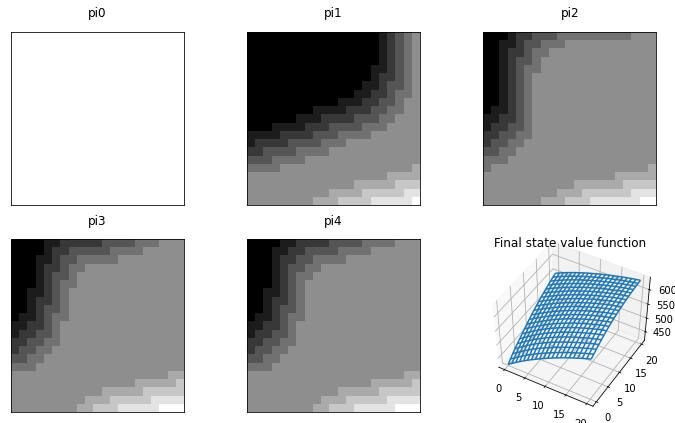

In [7]:
fig = plt.figure(figsize=(12,7))
c = 0
ax1 = []
for i in range(2):
  for j in range(3):
    c = c+1
    if (c == len(pi)+1):
      break
    pi_mat = dispAction(pi[c-1])
    ax1.append(fig.add_subplot(2, 3, c))
    ax1[c-1].matshow(pi_mat, cmap='binary')
    ax1[c-1].invert_yaxis()
    ax1[c-1].set_xticks([])
    ax1[c-1].set_yticks([])
    ax1[c-1].set_title('pi'+str(c-1))

from mpl_toolkits.mplot3d import axes3d
x = list(range(max_cars+1))
y = list(range(max_cars+1))
X,Y = np.meshgrid(x,y)
ax12 = fig.add_subplot(2, 3, 6, projection='3d')
ax12.set_title('Final state value function')
ax12.plot_wireframe(X, Y, vs)#, rstride=10, cstride=10)
ax12.view_init(elev=50., azim=-60)

## Approach with Action Value Function

In this section, we solve the same problem with the action value function instead of the state value function. The action value function approach has a couple of advantages over using the state value function approach.


*   The policy improvement using the state value function is a 1-step greedy approach, where the majority of the code for computing the best next step is repeated as in a single iteration of the policy evaluation. This is wasteful computation and can be avoided if we use the action value function instead.

The formulation of both approaches are a little bit different and it helps to analyze the equations closely.

$$\textbf{Action Value Function:  }  q_\pi (s,a) = \sum_{r,s'}{p(s',r|a,s) \left(r + \gamma \sum_{a'}{\pi(a'|s') q_\pi (s',a')}\right)}  $$

Note that in the second summation above, we sum the action value function w.r.t all possible actions available from the next state. As an example, let us consider



In [8]:
actions = list(range(-max_move,max_move+1))
qs_init = np.zeros((len(actions),max_cars+1,max_cars+1))
print(qs_init.shape)
pi_init = np.zeros((len(actions),max_cars+1,max_cars+1))
pi_init[max_move,:,:] = 1



(11, 21, 21)


In [17]:
def eval_action_policy(qs,pi):
  qs_new = np.copy(qs)
  error = 0
  for i in range(max_cars+1):
    for j in range(max_cars+1):
      s = [i,j]
      pi_s = pi[:,i,j]
      ind = np.where(pi_s > 0)[0]
      for idx,a in enumerate(actions):
        new_c1 = np.array(s) - a*np.array([1,-1])
        new_c = np.maximum(0,np.minimum(max_cars,new_c1))
        p_trans = prob_transition(new_c,p_rent_master,p_retn_master)
        E = expected_rental_reward(new_c,p_rent_master,rent_cost)
        new_val = 0
        for ii in range(max_cars+1):
          for jj in range(max_cars+1):
            pi_s_next = pi[:,ii,jj]
            ind_next = np.where(pi_s_next > 0)[0]
            q_next = 0
            for kk in ind_next:
              q_next = q_next + pi_s_next[kk]*qs_new[kk,ii,jj]
            new_val = new_val + gamma*p_trans[ii,jj]*q_next
        qs_new[idx,i,j] = E + move_cost*abs(a) + new_val
        error = max(error,np.abs(qs_new[idx,i,j]-qs[idx,i,j]))
  return qs_new,error

def imprv_action_policy(q_s):
  pi_new = np.zeros((len(actions),max_cars+1,max_cars+1))
  for i in range(max_cars+1):
    for j in range(max_cars+1):
      new_q = q_s[:,i,j]
      idx = np.where(new_q == np.max(new_q))[0]
      # if len(np.where(idx != 5)[0]) > 0:
      #   print(i,j,idx)
      pi_new[idx,i,j] = 1/float(len(idx))
  return pi_new

def action_policy_iteration(qs_init,pi_init,policy_iter_max,value_iter_max,error_tol):
  qs_prev = np.copy(qs_init)
  pi_prev = np.copy(pi_init)
  policy = [pi_prev]
  for k in range(policy_iter_max):
    iter = 0
    while iter < value_iter_max:
      qs_new,error = eval_action_policy(qs_prev,pi_prev)
      if iter%5 == 0:
        print(k,iter,error)
      qs_prev = np.copy(qs_new)
      if (error < error_tol):
        break
      iter = iter + 1
    # print(k,iter,error)
    pi_new = imprv_action_policy(qs_prev)
    if np.max(np.abs(pi_new-pi_prev)) <= 1E-3:
      print('Policy iteration converged after ',k,' iterations!')
      break
    pi_prev = np.copy(pi_new)
    policy.append(pi_prev)

  return policy,qs_prev

In [18]:
policy_iter_max = 10
value_iter_max = 100
error_tol = 0.1
action_policy,qs_final = action_policy_iteration(qs_init,pi_init,policy_iter_max,value_iter_max,error_tol)

0 0 210.173190830234
0 5 42.01005034301545
0 10 15.367406347701433
0 15 6.180206266078017
0 20 2.393012044082809
0 25 0.9083935811098058
0 30 0.3414025532435403
0 35 0.12766049026515702
1 0 52.683416619501656
1 5 2.7929783126925827
1 10 0.9859131755222279
1 15 0.3566584020415462
1 20 0.1292318716563159
2 0 4.613057847882374
2 5 0.7500761158680689
2 10 0.246171893818655
2 15 0.08714840619865072
3 0 0.4361208126344991
4 0 0.06374454063575286
Policy iteration converged after  4  iterations!


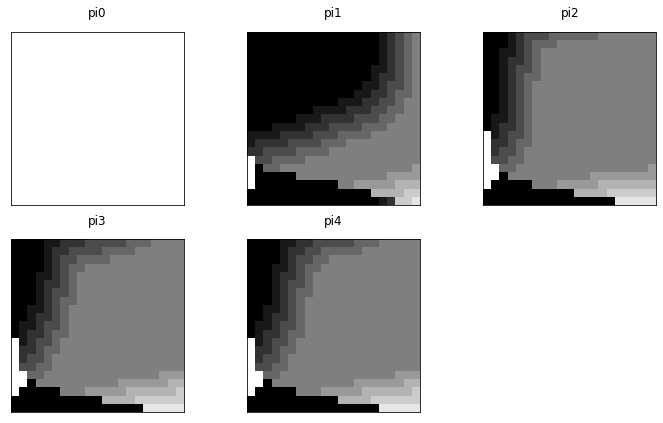

In [19]:
fig = plt.figure(figsize=(12,7))
c = 0
ax1 = []
for i in range(2):
  for j in range(3):
    c = c+1
    if (c == len(action_policy)+1):
      break
    pi_mat = dispAction(action_policy[c-1])
    ax1.append(fig.add_subplot(2, 3, c))
    ax1[c-1].matshow(pi_mat, cmap='binary')
    ax1[c-1].invert_yaxis()
    ax1[c-1].set_xticks([])
    ax1[c-1].set_yticks([])
    ax1[c-1].set_title('pi'+str(c-1))
